In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
training_data = pd.read_csv('../data/processed/NFL_verse_training_data.csv')

In [6]:
y = training_data['Injury']

train_numeric = training_data[['week','qtr', 'down', 'ydstogo','yardline_100','spread_line',
                    'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback',
                    'qb_scramble','season','overtime', 'div_game', 'wind', 'temp', 'score_differential']]

train_str = training_data[['game_half',
                    'play_type',
                    'pass_length','pass_location',
                    'run_location', 'run_gap','weekday','roof', 
                    'surface','stadium']]

In [7]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()
le = LabelEncoder()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca) 

for feat in train_str:
    train_str[feat] = le.fit_transform(train_str[feat].astype(str))

for feat in train_numeric:
    train_numeric[feat].fillna(train_numeric[feat].mean(), inplace=True)

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_49497/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_49497/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_49497/3165086785.py:12: SettingWithCopyWarning: 
A value is trying 

In [8]:
X_enc = pipeline.fit_transform(pd.concat([train_numeric, train_str], axis=1))

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=41)

In [10]:
df_processed = pd.DataFrame(
    data=X_enc, 
    index=pd.concat([train_numeric, train_str], axis=1).index, 
    columns=pd.concat([train_numeric, train_str], axis=1).columns
)

In [11]:
from sklearn.linear_model import LinearRegression


linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [12]:
#See the R-Squared
from sklearn.metrics import precision_score, recall_score


score = linr.score(X_test, y_test)
print("R-squared: {:.2f}".format(score))

#Now test the model
y_pred = linr.predict(X_test)
print('Training Set:', linr.score(X_train,y_train))
print('Test Set:', linr.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred, average='macro')*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred, average='macro')*100))


R-squared: 1.00
Training Set: 1.0
Test Set: 1.0
Precision: 100.00%
Recall: 100.00%


In [13]:
from sklearn.feature_selection import mutual_info_classif

combined_data = pd.concat([train_numeric, train_str], axis=1)
ig = mutual_info_classif(combined_data, y, random_state=42)
ig

array([8.84486114e-05, 2.65345834e-04, 6.63364585e-04, 6.19140279e-04,
       0.00000000e+00, 8.84486114e-05, 8.84486114e-05, 1.72474792e-03,
       1.32672917e-04, 1.45940209e-03, 0.00000000e+00, 3.09570140e-04,
       0.00000000e+00, 5.30691668e-04, 1.06138334e-03, 2.65345834e-04,
       1.32672917e-04, 7.07588891e-04, 1.06138334e-03, 6.63364585e-04,
       1.06138334e-03, 1.85742084e-03, 1.59207500e-03, 2.25543959e-03,
       1.59207500e-03, 6.63364585e-04, 1.32672917e-04])

In [14]:
# Create a dictionary to store the feature and its information gain
ig_dict = {}
for i in range(len(combined_data.columns)):
    ig_dict[combined_data.columns[i]] = ig[i]

In [15]:
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top n features with the highest information gain
n = 10
selected_features = list(ig_dict_sorted.keys())[:n]

# Print the selected features
print('Selected Features:')
print(selected_features)

Selected Features:
['weekday', 'run_location', 'shotgun', 'run_gap', 'roof', 'qb_dropback', 'wind', 'play_type', 'pass_location', 'game_half']


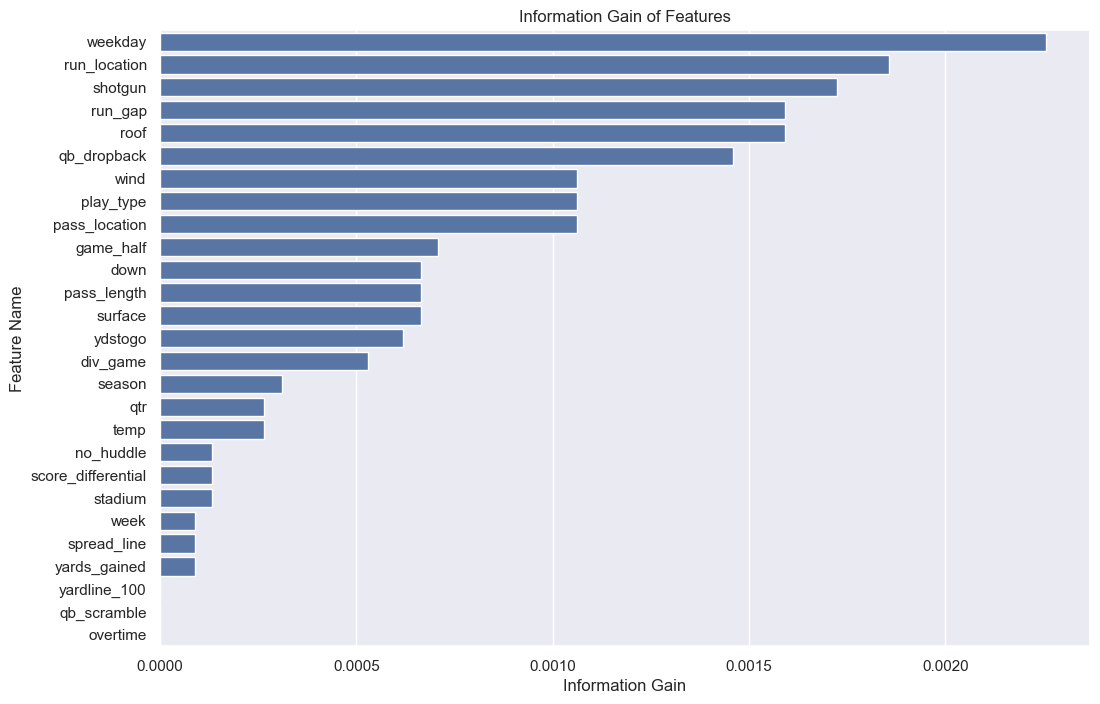

In [16]:
# Visualize the information gain of each feature
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=list(ig_dict_sorted.values()), y=list(ig_dict_sorted.keys()))
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
plt.show()